In [4]:
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import time
import re
from tqdm import tqdm
import json
from io import StringIO
import random

In [5]:
def get_player_stats_for_year(year, headers):
    """
    Fetches and merges the Advanced and Per Game stats for a single NBA season.

    Args:
        year (int): The year of the season to fetch.
        headers (dict): The User-Agent header to use for the request.

    Returns:
        pandas.DataFrame: A merged DataFrame of stats for the season, or None.
    """
    # Fetch Advanced Stats
    advanced_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
    try:
        response = requests.get(advanced_url, headers=headers, timeout=15)
        response.raise_for_status()
        advanced_df = pd.read_html(StringIO(response.text))[0]
    except Exception as e:
        print(f"Could not fetch advanced stats for {year}: {e}")
        return None

    # Fetch Per Game Stats
    per_game_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
    try:
        response = requests.get(per_game_url, headers=headers, timeout=15)
        response.raise_for_status()
        per_game_df = pd.read_html(StringIO(response.text))[0]
    except Exception as e:
        print(f"Could not fetch per game stats for {year}: {e}")
        return None

    # Clean up and merge the dataframes
    advanced_df = advanced_df.drop(advanced_df[advanced_df['Age'] == 'Age'].index)
    per_game_df = per_game_df.drop(per_game_df[per_game_df['Age'] == 'Age'].index)

    # Select only the columns we need to avoid duplicates
    per_game_subset = per_game_df[['Player', 'Pos', 'Age', 'Team', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]

    # Merge, ensuring player names are consistent
    merged_df = pd.merge(advanced_df, per_game_subset, on="Player", suffixes=('_adv', '_pg'))
    merged_df['Season'] = f"{year}"
    merged_df.drop(columns=['Rk_adv', 'Rk_pg'], errors='ignore', inplace=True)
    merged_df.drop(columns=['Age_adv', 'Team_adv', 'Pos_adv', 'G_adv', 'GS_adv', 'MP_adv', 'Awards_adv', 'Awards_pg'], errors='ignore', inplace=True)
    merged_df.rename(columns={
        'Age_pg': 'Age',
        'Team_pg': 'Team',
        'Pos_pg': 'Pos',
        'G_pg': 'G',
        'GS_pg': 'GS',
        'MP_pg': 'MP'}, inplace=True)

    return merged_df

In [6]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Referer': 'https://www.google.com/',
    'Connection': 'keep-alive'
}

all_elite_players = []

# Get elite players from each season
current_year = pd.Timestamp.now().year
for year in tqdm(range(2000, current_year + 1), desc="Scanning Seasons for Elite Players"):
    season_stats = get_player_stats_for_year(year, headers)
    if season_stats is not None:
        season_stats['PER'] = pd.to_numeric(season_stats['PER'], errors='coerce')
        season_stats['G'] = pd.to_numeric(season_stats['G'], errors='coerce')
        elite_in_year = season_stats[(season_stats['PER'] >= 20) & (season_stats['G'] >= 41)]
        elite_in_year.loc[:, 'Player'] = elite_in_year['Player'].str.replace('*', '', regex=False)
        all_elite_players.append(elite_in_year)
    time.sleep(random.uniform(5, 10))

# Merge all elite players across seasons
all_elite_df = pd.concat(all_elite_players, ignore_index=True)
print(f"\nCollected {len(all_elite_df)} elite player-season entries. Now filtering for each player's prime season...")

# Keep only the season where each player had the highest PER
merged_all_elite_df = all_elite_df.loc[all_elite_df.groupby('Player')['PER'].idxmax().values].reset_index(drop=True)

# Export to CSV
merged_all_elite_df.to_csv("elite_players_prime_seasons.csv", index=False)

# Export to JSON
merged_all_elite_df.to_json("elite_players_prime_seasons.json", orient='records', indent=2)


Scanning Seasons for Elite Players: 100%|██████████| 26/26 [03:45<00:00,  8.68s/it]


Collected 1040 elite player-season entries. Now filtering for each player's prime season...


In [13]:
# Normalize relevant metrics
df = merged_all_elite_df.copy()
for col in ['PER', 'WS', 'BPM', 'VORP', 'PTS']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col + '_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Composite score with custom weights
df['score'] = (
    0.4 * df['PER_norm'] +
    0.2 * df['WS_norm'] +
    0.2 * df['BPM_norm'] +
    0.1 * df['VORP_norm'] +
    0.1 * df['PTS_norm']
)

top_100 = df.sort_values(by='score', ascending=False).head(100)
top_100 = top_100[top_100['Player'] != 'Greg Monroe'] #Anomoly
top_100 = top_100.reset_index(drop=True)


#✅ 1. Export the Result

In [14]:
top_100.to_csv("top_100_elite_players.csv", index=False)
top_100.to_json("top_100_elite_players.json", orient='records', indent=2)


#📊 2. Analysis and Visualization
## a. Top 10 Players

In [15]:
print(top_100[['Player', 'Team', 'Pos', 'PER', 'WS', 'BPM', 'VORP', 'PTS', 'score']].head(10))


                    Player Team Pos   PER    WS   BPM  VORP   PTS     score
0             LeBron James  CLE  SF  31.7  20.3  13.2  11.8  28.4  0.611726
1            Stephen Curry  GSW  PG  31.5  17.9  11.9   9.5  30.1  0.562801
2            Nikola JokiÄ  DEN   C  32.8  15.2  13.7   9.8  27.1  0.554936
3             Kevin Durant  OKC  SF  29.8  19.2  10.2   9.6  32.0  0.553615
4  Shai Gilgeous-Alexander  OKC  PG  30.7  16.7  11.5   8.9  32.7  0.542880
5         Shaquille O'Neal  LAL   C  30.6  18.6   9.3   9.0  29.7  0.537644
6             James Harden  HOU  PG  30.6  15.2  11.0   9.3  36.1  0.537041
7            Tracy McGrady  ORL  SG  30.3  16.1  10.5   9.3  32.1  0.527719
8               Chris Paul  NOH  PG  30.0  18.3  11.0   9.9  22.8  0.527457
9            Kevin Garnett  MIN  PF  29.4  18.3  10.2  10.0  24.2  0.521008


## b. Distribution of Positions

/tmp/ipython-input-16-863973975.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=top_100, x='Pos', order=top_100['Pos'].value_counts().index, palette='viridis')


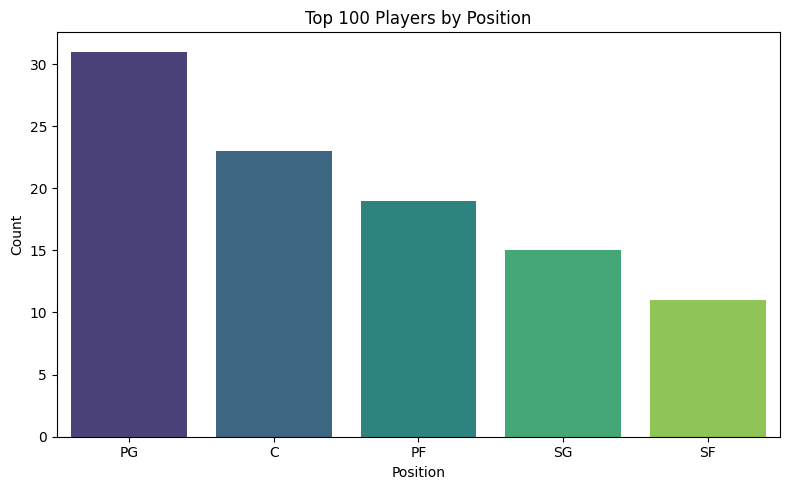

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=top_100, x='Pos', order=top_100['Pos'].value_counts().index, palette='viridis')
plt.title("Top 100 Players by Position")
plt.xlabel("Position")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## c. Score vs PER Scatter Plot

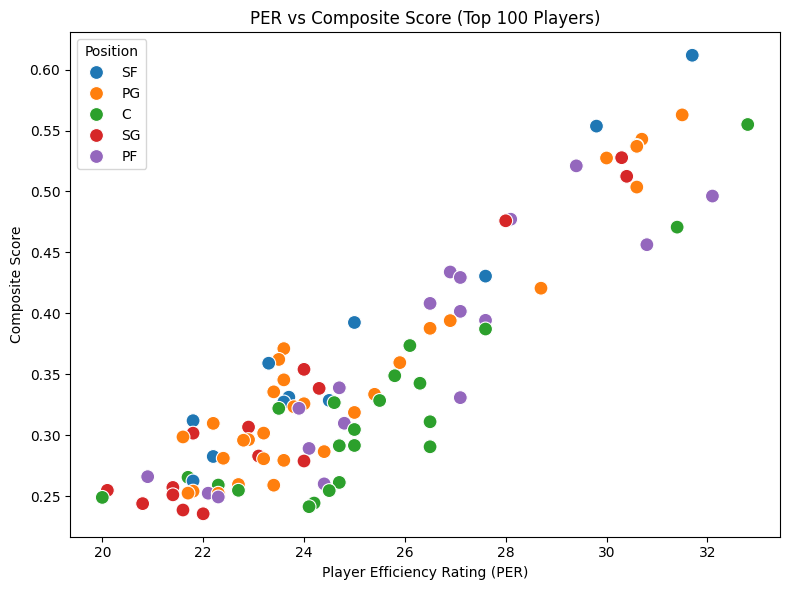

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=top_100, x='PER', y='score', hue='Pos', palette='tab10', s=100)
plt.title("PER vs Composite Score (Top 100 Players)")
plt.xlabel("Player Efficiency Rating (PER)")
plt.ylabel("Composite Score")
plt.legend(title="Position")
plt.tight_layout()
plt.show()


## d. Heatmap of Top 15 Players’ Stats

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 135 (\x87) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


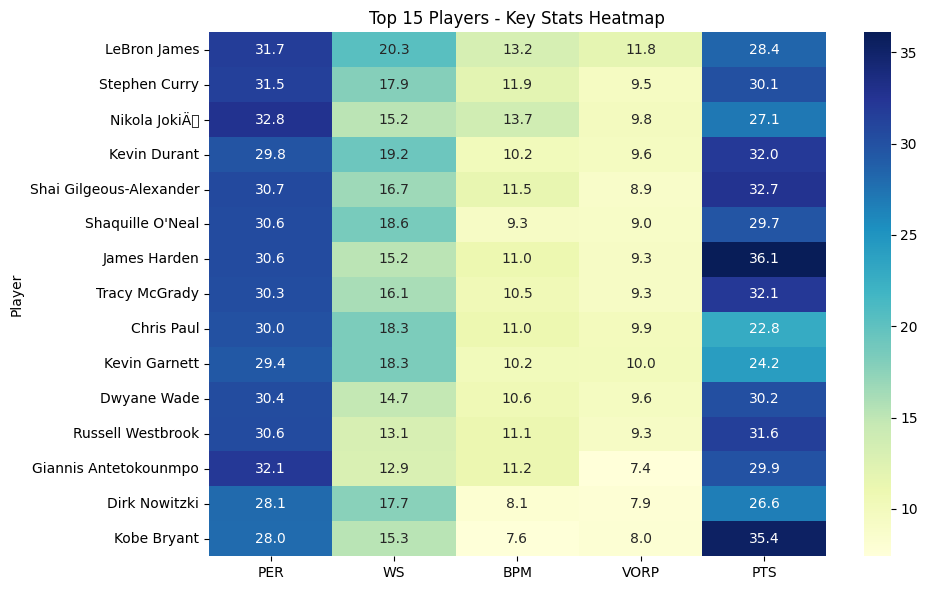

In [18]:
metrics = ['PER', 'WS', 'BPM', 'VORP', 'PTS']
top_15 = top_100.head(15).set_index('Player')[metrics]

plt.figure(figsize=(10, 6))
sns.heatmap(top_15, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title("Top 15 Players - Key Stats Heatmap")
plt.tight_layout()
plt.show()


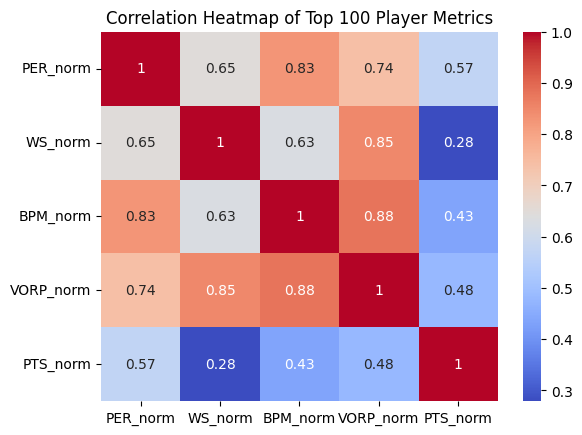

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(top_100[['PER_norm', 'WS_norm', 'BPM_norm', 'VORP_norm', 'PTS_norm']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Top 100 Player Metrics')
plt.show()


## 🔹 5. Position-wise Boxplots
- Explore how scores vary by position.

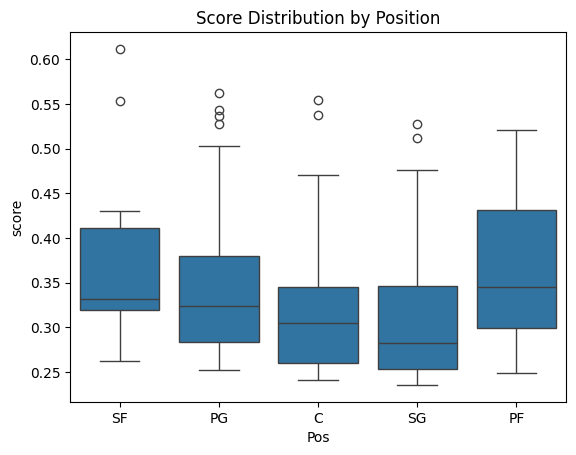

In [20]:
sns.boxplot(x='Pos', y='score', data=top_100)
plt.title('Score Distribution by Position')
plt.show()
